# General Analysis of Data Received

## Configuration

In [1]:
import warnings
warnings.filterwarnings('ignore')

%matplotlib widget
import matplotlib.pyplot as plt

import pandas as pd

import numpy as np
from scipy.interpolate import interp1d
from scipy import stats

## Log analysis

In [2]:
# that means events.log and output.log are the same, except for a warning like a notice
! diff -U 0 ../data_received/events.log ../data_received/output.log

--- ../data_received/events.log	2023-06-17 14:44:38.000000000 +0200
+++ ../data_received/output.log	2023-06-17 14:44:38.000000000 +0200
@@ -63,0 +64,2 @@
+/home/sandbox/msl/DgVeneto/main.py:64: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
+  data = np.fromstring(


In [3]:
! head -n 10 ../data_received/output.log

[I 230512 12:46:07 main:223] Experiment started
[I 230512 12:46:07 main:247] Iteration 1 started
[I 230512 12:46:07 main:247] Iteration 2 started
[I 230512 12:46:07 main:247] Iteration 3 started
[I 230512 12:46:07 main:247] Iteration 4 started
[I 230512 12:46:08 main:247] Iteration 5 started
[I 230512 12:46:08 main:247] Iteration 6 started
[I 230512 12:46:08 main:247] Iteration 7 started
[I 230512 12:46:08 main:247] Iteration 8 started
[I 230512 12:46:08 main:247] Iteration 9 started


In [4]:
# that means there are not other warnings or similar lines
! grep -v 230512 ../data_received/output.log

/home/sandbox/msl/DgVeneto/main.py:64: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(


In [5]:
! grep -v Iteration ../data_received/output.log | head -n 10

[I 230512 12:46:07 main:223] Experiment started
[I 230512 12:46:09 main:150] Motion detected
[I 230512 12:46:10 main:150] Motion detected
/home/sandbox/msl/DgVeneto/main.py:64: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(
[I 230512 12:46:20 main:159] Humans detected: 0
[I 230512 12:46:22 main:150] Motion detected
[I 230512 12:46:22 main:150] Motion detected
[I 230512 12:46:33 main:159] Humans detected: 0
[I 230512 12:46:45 main:159] Humans detected: 0


In [6]:
# that means there are 50520 samples
! grep -c Iteration ../data_received/output.log

50520


In [7]:
# that means there are 4541 samples with motion detections valued
! grep -c Motion ../data_received/output.log

4541


In [8]:
# that means there are 842 samples with humans detections
! grep -c Human ../data_received/output.log

842


In [9]:
# that means all 842 samples are valued to zero: no humans detection
! grep -c "Humans detected: 0" ../data_received/output.log

842


In [10]:
! wc -l ../data_received/output.log

   55907 ../data_received/output.log


In [11]:
55907 - 50520 - 4541 - 842

4

In [12]:
! grep -v Iteration ../data_received/output.log | grep -v Motion | grep -v Human 

[I 230512 12:46:07 main:223] Experiment started
/home/sandbox/msl/DgVeneto/main.py:64: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  data = np.fromstring(
[I 230512 15:43:07 main:287] Experiment finished successfully!


In [13]:
# that means there are the same samples that we have seen in the log
! wc -l ../data_received/data.csv

   50521 ../data_received/data.csv


## Data analysis

### Loading

In [14]:
data = pd.read_csv('../data_received/data.csv', parse_dates=[1])
data

counter                  date_time   latitude  longitude  temperature  \
0            1 2023-05-12 12:46:07.736418 -20.280044  66.778678    36.840515   
1            2 2023-05-12 12:46:07.854780 -20.267939  66.788942    37.516163   
2            3 2023-05-12 12:46:07.969193 -20.262172  66.793830    36.538254   
3            4 2023-05-12 12:46:08.091250 -20.256596  66.798557    36.591595   
4            5 2023-05-12 12:46:08.213893 -20.250645  66.803602    36.538254   
...        ...                        ...        ...        ...          ...   
50515    50516 2023-05-12 15:43:01.290492 -42.989342  -8.462060    39.027477   
50516    50517 2023-05-12 15:43:01.410310 -42.984984  -8.453165    38.245148   
50517    50518 2023-05-12 15:43:01.524929 -42.980864  -8.444756    38.227371   
50518    50519 2023-05-12 15:43:01.652360 -42.976913  -8.436696    38.191811   
50519    50520 2023-05-12 15:43:07.497472 -42.972460  -8.427614    39.169720   

        humidity     pressure       pitch       roll         yaw  ...  \
0      26.103346  1003.663574  334.094310  68.263185  248.996435  ...   
1      24.711226  1003.647461  334.250341  68.495343  248.985623  ...   
2      26.054394  1003.652588  334.274408  68.671084  249.085869  ...   
3      26.317518  1003.658203  334.308862  68.791377  249.229187  ...   
4      26.265505  1003.665283  334.372377  68.915366  249.367622  ...   
...          ...          ...         ...        ...         ...  ...   
50515  26.173717  1003.343994  336.326093  67.004415  280.192559  ...   
50516  24.576603  1003.344971  336.275374  67.105454  280.295155  ...   
50517  24.650034  1003.342285  336.327451  67.081924  280.770400  ...   
50518  24.830551  1003.342285  336.364110  67.107319  281.021635  ...   
50519  26.204313  1003.335205  336.408882  67.045041  281.175840  ...   

        accel_y   accel_z    gyro_x    gyro_y    gyro_z     mag_x     mag_y  \
0      0.035624  0.012200  0.008112  0.009121 -0.004015 -4.093543 -0.093616   
1      0.036600  0.015372  0.006030  0.007092 -0.000578 -5.652378 -0.240464   
2      0.036844  0.011468  0.008623  0.006622 -0.000706 -6.211312 -0.319537   
3      0.038308  0.013176  0.009038  0.005563 -0.003603 -6.320467 -0.230821   
4      0.036844  0.012200  0.006709  0.006996 -0.002215 -6.534536 -0.331418   
...         ...       ...       ...       ...       ...       ...       ...   
50515  0.037088  0.015860  0.000566 -0.000544 -0.001125  4.188752  7.835399   
50516  0.038308  0.014884  0.002093  0.001899  0.001319  4.835254  7.946895   
50517  0.036844  0.014396 -0.000655  0.000372 -0.000819  4.386203  7.978561   
50518  0.037576  0.017080 -0.000961  0.000677  0.002235  4.170645  8.040040   
50519  0.038308  0.016348  0.000566 -0.000545 -0.001125  4.212351  7.917285   

           mag_z  motion_detected  humans_detected  
0      -7.216313                0                0  
1     -10.395998                0                0  
2     -11.458225                0                0  
3     -11.740249                0                0  
4     -12.010340                0                0  
...          ...              ...              ...  
50515  -5.667742                0                0  
50516  -5.575324                0                0  
50517  -5.541205                0                0  
50518  -5.712568                0                0  
50519  -5.425406                0                0  

[50520 rows x 21 columns]

In [15]:
data.describe().T

count          mean           std          min  \
counter          50520.0  25260.500000  14584.012137     1.000000   
latitude         50520.0      1.544148     35.308444   -51.795325   
longitude        50520.0    -12.854990    106.711420  -179.991312   
temperature      50520.0     38.309752      0.485445    36.129311   
humidity         50520.0     25.081152      0.753351    21.611845   
pressure         50520.0   1003.567545      0.119742  1003.266846   
pitch            50520.0    336.243092      0.360865   333.919693   
roll             50520.0     67.040813      0.362860    65.125936   
yaw              50520.0    222.318328    145.099451     0.000042   
accel_x          50520.0      0.017959      0.000889     0.010736   
accel_y          50520.0      0.037509      0.000920     0.033428   
accel_z          50520.0      0.015915      0.001411     0.005612   
gyro_x           50520.0      0.000257      0.001641    -0.007651   
gyro_y           50520.0      0.000237      0.001939    -0.080729   
gyro_z           50520.0     -0.000061      0.001138    -0.005232   
mag_x            50520.0     26.871291     21.316950    -6.895558   
mag_y            50520.0      0.651699      2.653172    -3.052538   
mag_z            50520.0     -6.592632     11.294922   -29.595072   
motion_detected  50520.0      0.089885      0.286020     0.000000   
humans_detected  50520.0      0.000000      0.000000     0.000000   

                          25%           50%           75%           max  
counter          12630.750000  25260.500000  37890.250000  50520.000000  
latitude           -32.413823      3.278728     35.174568     51.795550  
longitude         -113.189944    -23.528553     83.893184    179.997609  
temperature         38.102909     38.351830     38.547413     39.329742  
humidity            24.692867     24.965174     25.485306     29.083403  
pressure          1003.471191   1003.577026   1003.658203   1003.851807  
pitch              336.127039    336.301299    336.449058    337.607990  
roll                66.826253     67.040916     67.241360     70.219344  
yaw                 22.054753    292.477863    341.105909    359.997880  
accel_x              0.017324      0.018056      0.018544      0.024156  
accel_y              0.036844      0.037576      0.038064      0.041480  
accel_z              0.014884      0.015860      0.016836      0.023912  
gyro_x              -0.000871      0.000258      0.001345      0.009038  
gyro_y              -0.000709      0.000236      0.001164      0.074777  
gyro_z              -0.000851     -0.000042      0.000687      0.004247  
mag_x                4.694317     23.759969     48.847551     61.452736  
mag_y               -1.080424     -0.358765      1.820212      8.792371  
mag_z              -15.332492     -3.673741      2.553849      9.298397  
motion_detected      0.000000      0.000000      0.000000      1.000000  
humans_detected      0.000000      0.000000      0.000000      0.000000

In [16]:
# that means only some features have a wide range of values 
analysis = data.describe().T
analysis[analysis['std'] > 1]

count          mean           std         min           25%  \
counter    50520.0  25260.500000  14584.012137    1.000000  12630.750000   
latitude   50520.0      1.544148     35.308444  -51.795325    -32.413823   
longitude  50520.0    -12.854990    106.711420 -179.991312   -113.189944   
yaw        50520.0    222.318328    145.099451    0.000042     22.054753   
mag_x      50520.0     26.871291     21.316950   -6.895558      4.694317   
mag_y      50520.0      0.651699      2.653172   -3.052538     -1.080424   
mag_z      50520.0     -6.592632     11.294922  -29.595072    -15.332492   

                    50%           75%           max  
counter    25260.500000  37890.250000  50520.000000  
latitude       3.278728     35.174568     51.795550  
longitude    -23.528553     83.893184    179.997609  
yaw          292.477863    341.105909    359.997880  
mag_x         23.759969     48.847551     61.452736  
mag_y         -0.358765      1.820212      8.792371  
mag_z         -3.673741      2.553849      9.298397

### motion_detected

In [17]:
# that means motion_detected is True on average every 10 samples
data['motion_detected'].value_counts()

0    45979
1     4541
Name: motion_detected, dtype: int64

<Axes: xlabel='datetime'>

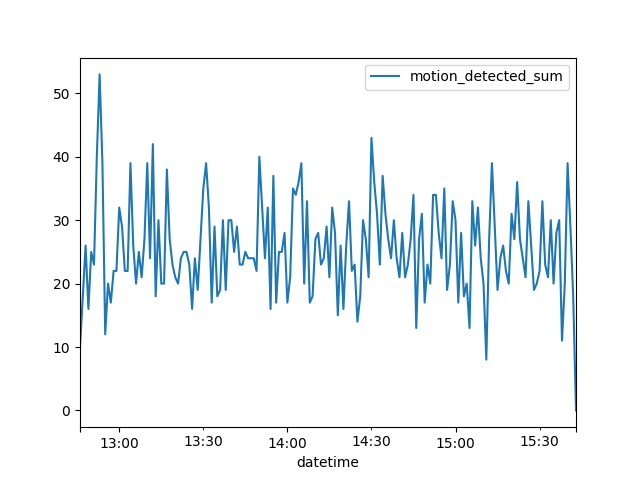

In [18]:
# that is the distribution per minutes of motion_detected values
data['datetime'] = data['date_time'].dt.floor('min')
analysis = data.groupby('datetime').agg(motion_detected_sum=('motion_detected', 'sum'))
analysis.plot()

<Axes: xlabel='datetime'>

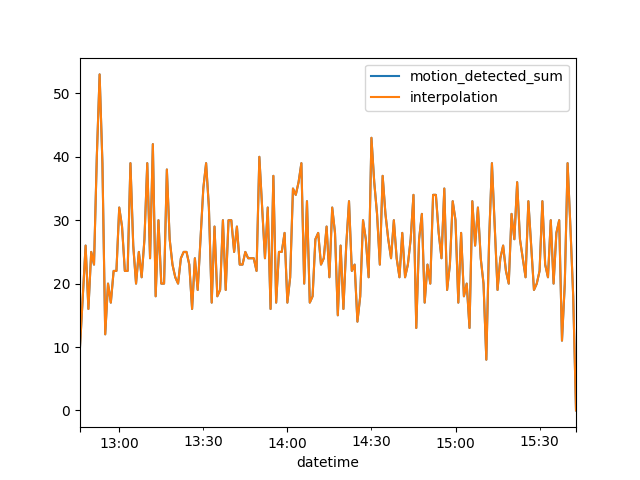

In [19]:
# interpolation is not sufficient to see something more significant
analysis.reset_index(inplace=True)
interpolation = interp1d(analysis.index, analysis['motion_detected_sum'], kind='cubic')
analysis['interpolation'] = interpolation(analysis.index)
analysis.set_index('datetime').plot(y=['motion_detected_sum', 'interpolation'])

<Axes: xlabel='datetime'>

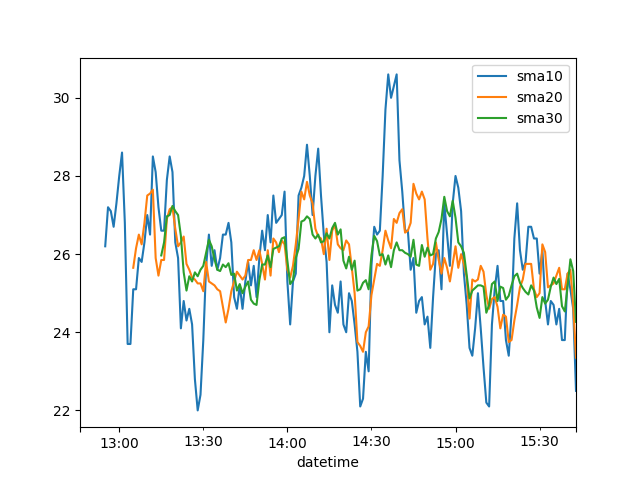

In [20]:
# maybe Simple Moving Average each 10, 20 and 30 samples, it exhibits a behavior
analysis['sma10'] = analysis['motion_detected_sum'].rolling(10).mean()
analysis['sma20'] = analysis['motion_detected_sum'].rolling(20).mean()
analysis['sma30'] = analysis['motion_detected_sum'].rolling(30).mean()
analysis.set_index('datetime').plot(y=['sma10', 'sma20', 'sma30'])

### humans_detected

In [21]:
# that means there are only humans_detected valued to zero
data['humans_detected'].value_counts()

0    50520
Name: humans_detected, dtype: int64

### Plotting

In [22]:
# add analysis with motion_detected_sum, sma10, sma20 and sma30
data = data.merge(analysis, on='datetime')
data.set_index('date_time', inplace=True)

In [23]:
data.columns

Index(['counter', 'latitude', 'longitude', 'temperature', 'humidity',
       'pressure', 'pitch', 'roll', 'yaw', 'accel_x', 'accel_y', 'accel_z',
       'gyro_x', 'gyro_y', 'gyro_z', 'mag_x', 'mag_y', 'mag_z',
       'motion_detected', 'humans_detected', 'datetime', 'motion_detected_sum',
       'interpolation', 'sma10', 'sma20', 'sma30'],
      dtype='object')

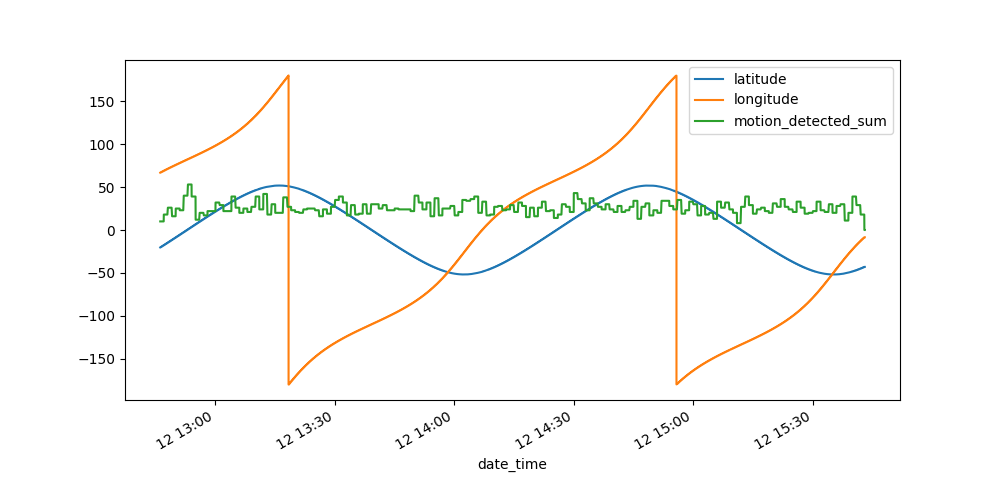

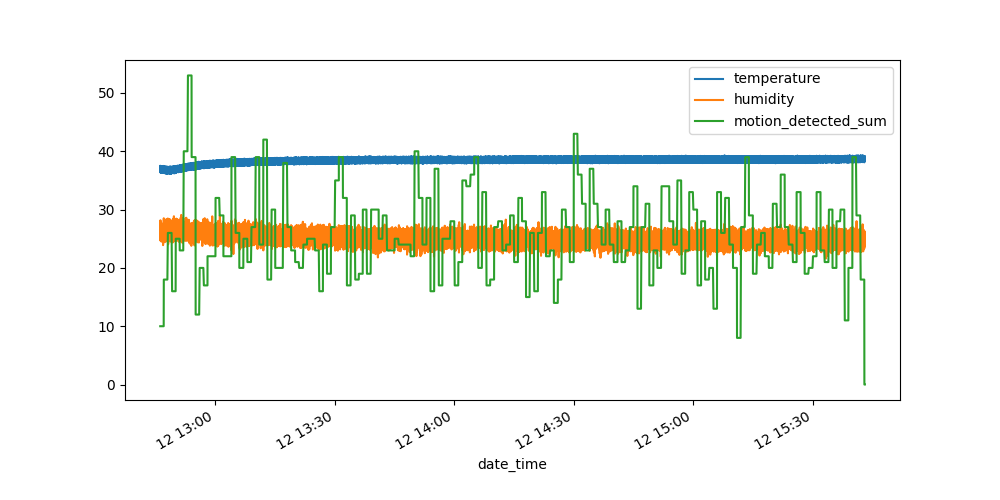

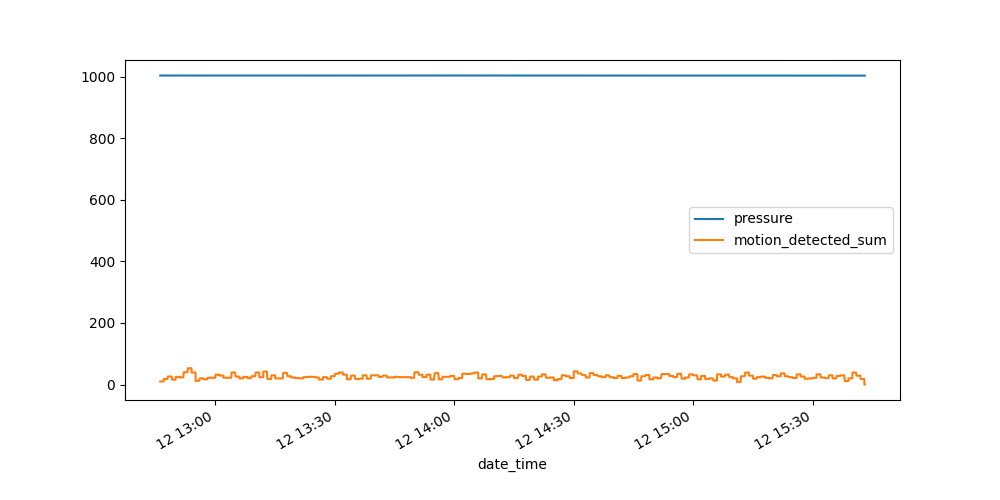

In [24]:
for motion_detected in ['motion_detected_sum']:#, 'sma10', 'sma20', 'sma30']:
    fig, ax = plt.subplots()
    data[['latitude', 'longitude', motion_detected]].plot(ax=ax, figsize=(10, 5))
    ax.legend(['latitude', 'longitude', motion_detected])
    fig, ax = plt.subplots()
    data[['temperature', 'humidity', motion_detected]].plot(ax=ax, figsize=(10, 5))
    ax.legend(['temperature', 'humidity', motion_detected])
    fig, ax = plt.subplots()
    data[['pressure', motion_detected]].plot(ax=ax, figsize=(10, 5))
    ax.legend(['pressure', motion_detected])

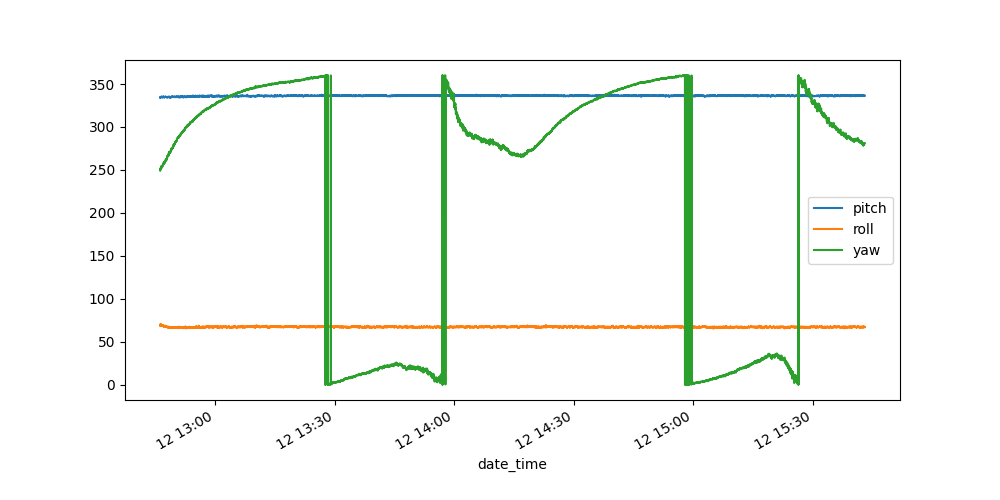

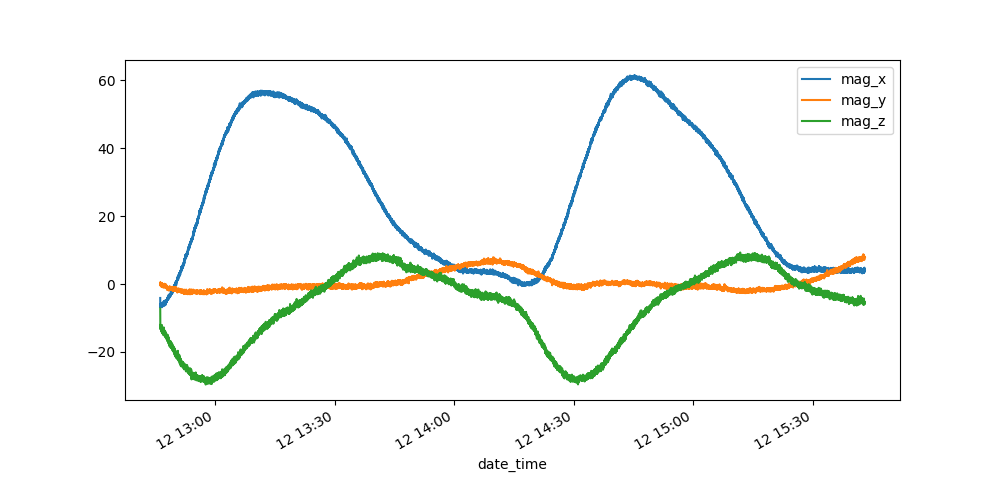

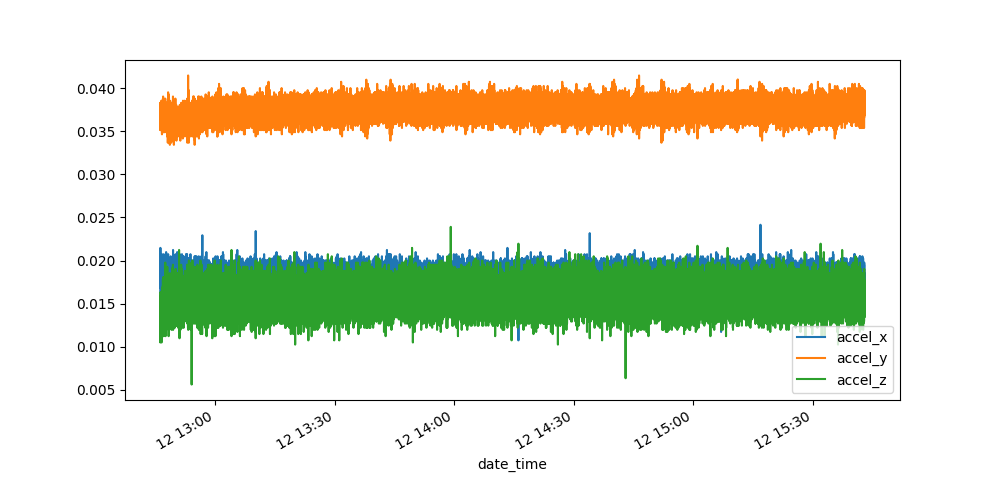

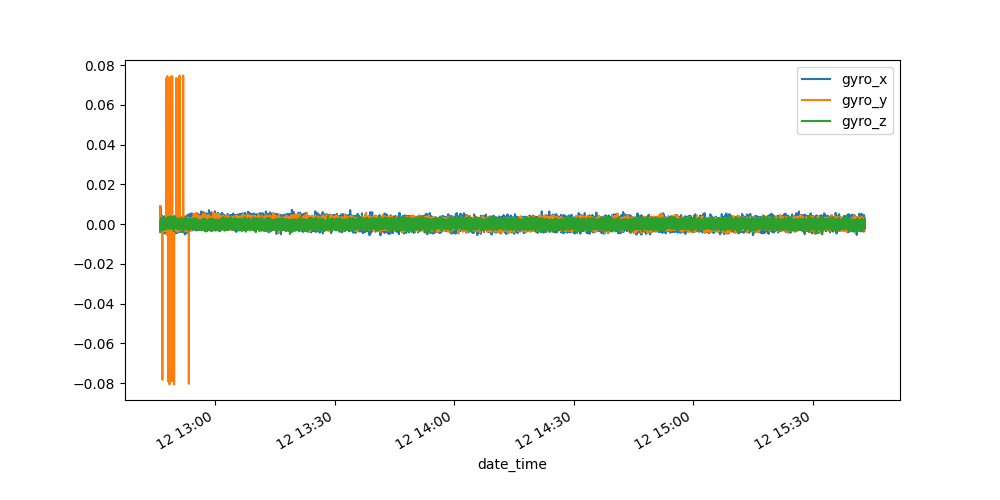

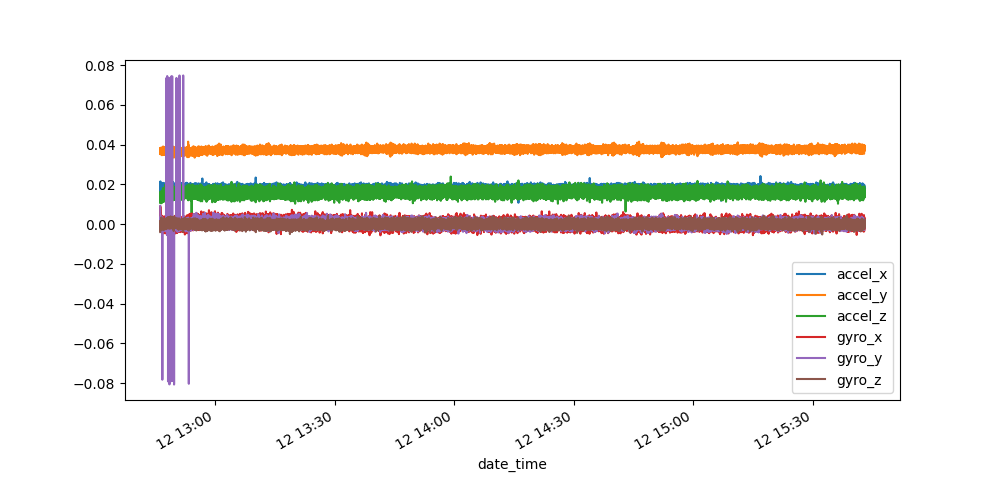

In [25]:
for metrics in [['pitch', 'roll', 'yaw'],
       ['mag_x', 'mag_y', 'mag_z'],
       ['accel_x', 'accel_y', 'accel_z'],
       ['gyro_x', 'gyro_y', 'gyro_z'],
       ['accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']]:
       legend = []
       for m in metrics:
              legend.append(m)
       fig, ax = plt.subplots()
       data[metrics].plot(ax=ax, figsize=(10, 5))
       ax.legend(legend)

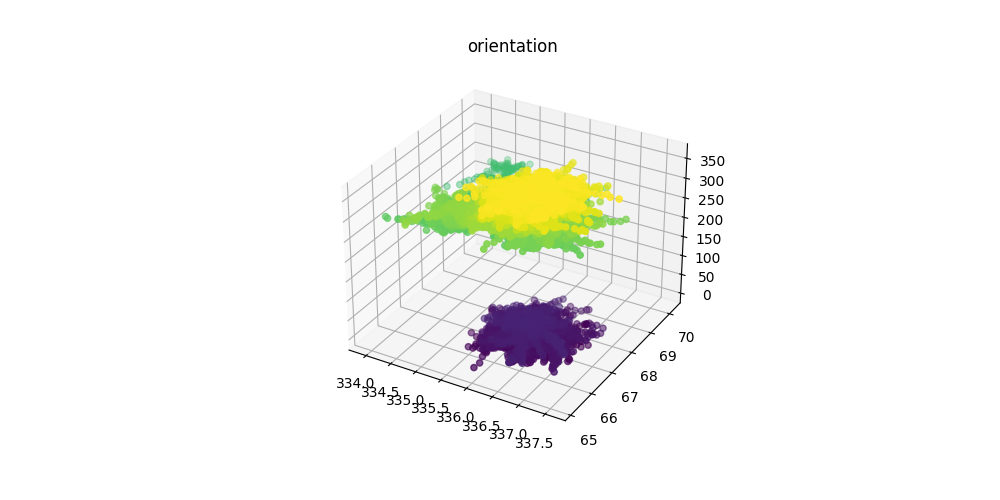

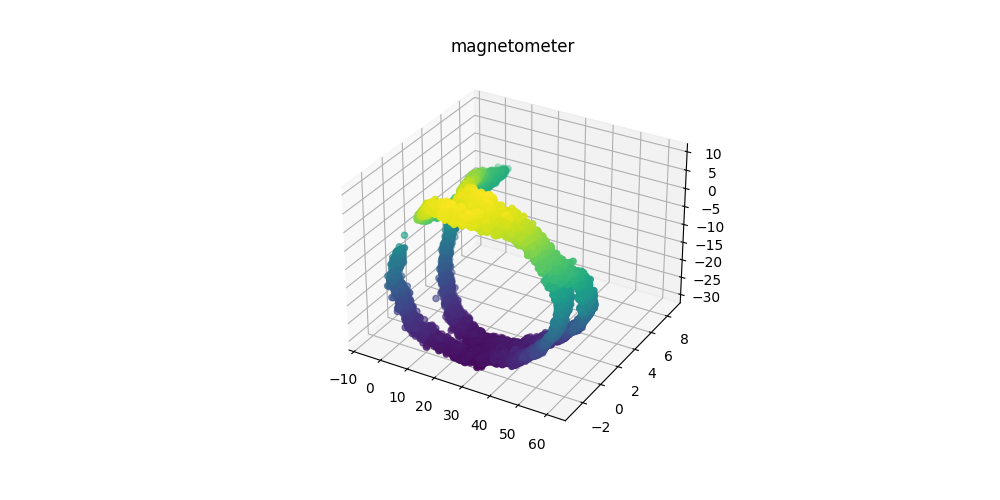

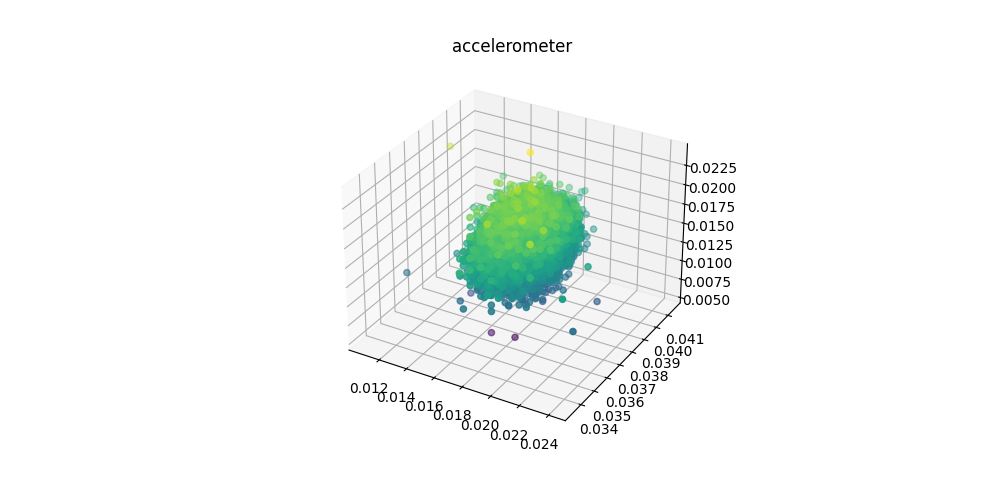

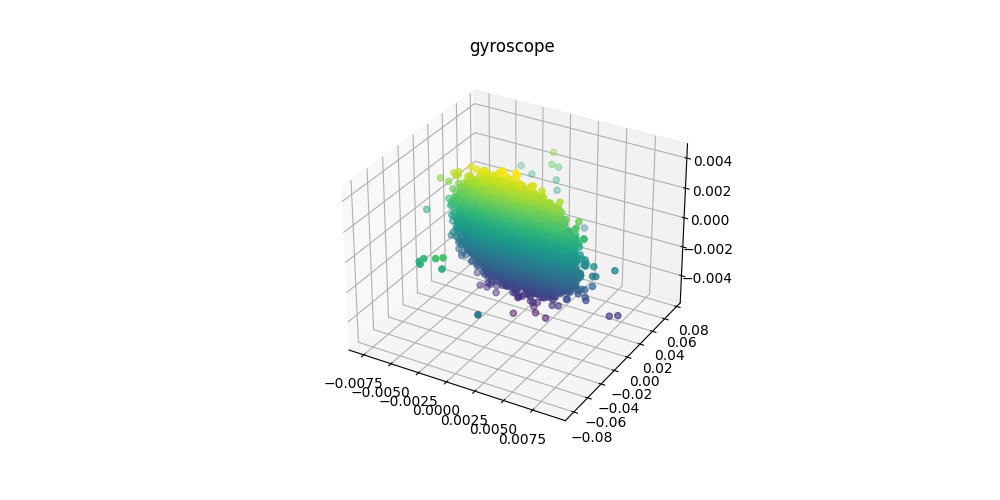

In [26]:
for metrics in [['orientation', 'pitch', 'roll', 'yaw'],
       ['magnetometer', 'mag_x', 'mag_y', 'mag_z'],
       ['accelerometer', 'accel_x', 'accel_y', 'accel_z'],
       ['gyroscope', 'gyro_x', 'gyro_y', 'gyro_z']]:
       fig = plt.figure(figsize=(10, 5))
       ax = plt.axes(projection='3d')
       ax.scatter3D(data[metrics[1]], data[metrics[2]], data[metrics[3]], c=data[metrics[3]], cmap='viridis');
       plt.title(metrics[0])

<Axes: xlabel='datetime'>

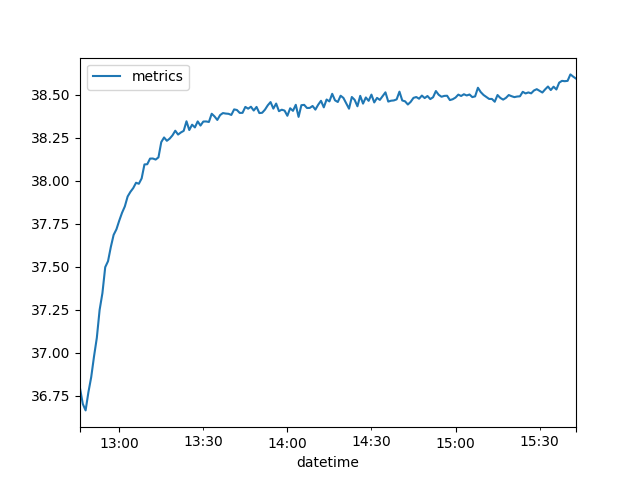

In [27]:
# that means the astropi was cold, it has been resumed for our job
data.groupby('datetime').agg(metrics=('temperature', 'mean')).plot()

<Axes: xlabel='datetime'>

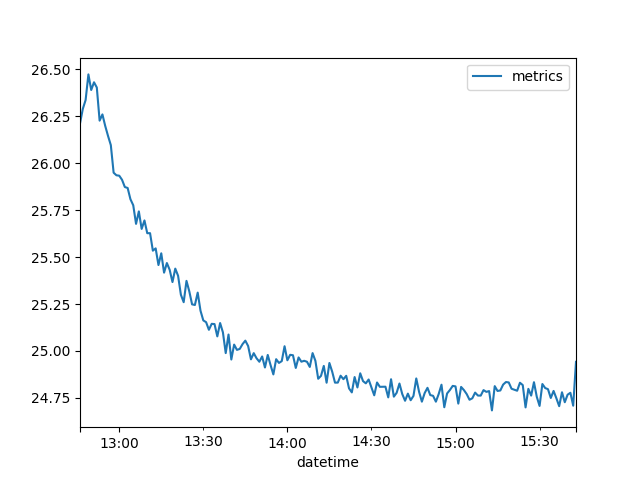

In [28]:
# that means the humidity has dropped because it has been resumed for our job
data.groupby('datetime').agg(metrics=('humidity', 'mean')).plot()

### Correlation detection

In [29]:
# add average for each metrics
for metrics in ['temperature', 'humidity', 'pressure', 'pitch', 'roll', 'yaw', 'mag_x', 'mag_y', 'mag_z', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']:
    label = metrics + '_avg'
    analysis = data.groupby('datetime').agg(metrics=(metrics, 'mean'))
    analysis.columns = [label]
    data = data.merge(analysis, on='datetime')
data

counter   latitude  longitude  temperature   humidity     pressure  \
0            1 -20.280044  66.778678    36.840515  26.103346  1003.663574   
1            2 -20.267939  66.788942    37.516163  24.711226  1003.647461   
2            3 -20.262172  66.793830    36.538254  26.054394  1003.652588   
3            4 -20.256596  66.798557    36.591595  26.317518  1003.658203   
4            5 -20.250645  66.803602    36.538254  26.265505  1003.665283   
...        ...        ...        ...          ...        ...          ...   
50515    50516 -42.989342  -8.462060    39.027477  26.173717  1003.343994   
50516    50517 -42.984984  -8.453165    38.245148  24.576603  1003.344971   
50517    50518 -42.980864  -8.444756    38.227371  24.650034  1003.342285   
50518    50519 -42.976913  -8.436696    38.191811  24.830551  1003.342285   
50519    50520 -42.972460  -8.427614    39.169720  26.204313  1003.335205   

            pitch       roll         yaw   accel_x  ...     yaw_avg  \
0      334.094310  68.263185  248.996435  0.016348  ...  253.804966   
1      334.250341  68.495343  248.985623  0.018300  ...  253.804966   
2      334.274408  68.671084  249.085869  0.018544  ...  253.804966   
3      334.308862  68.791377  249.229187  0.019032  ...  253.804966   
4      334.372377  68.915366  249.367622  0.018056  ...  253.804966   
...           ...        ...         ...       ...  ...         ...   
50515  336.326093  67.004415  280.192559  0.018056  ...  280.334830   
50516  336.275374  67.105454  280.295155  0.016836  ...  280.334830   
50517  336.327451  67.081924  280.770400  0.017812  ...  280.334830   
50518  336.364110  67.107319  281.021635  0.018544  ...  280.334830   
50519  336.408882  67.045041  281.175840  0.018056  ...  280.334830   

       mag_x_avg  mag_y_avg  mag_z_avg  accel_x_avg  accel_y_avg  accel_z_avg  \
0      -6.208867  -0.242112 -13.335208     0.018516     0.036697     0.013996   
1      -6.208867  -0.242112 -13.335208     0.018516     0.036697     0.013996   
2      -6.208867  -0.242112 -13.335208     0.018516     0.036697     0.013996   
3      -6.208867  -0.242112 -13.335208     0.018516     0.036697     0.013996   
4      -6.208867  -0.242112 -13.335208     0.018516     0.036697     0.013996   
...          ...        ...        ...          ...          ...          ...   
50515   4.041891   7.971319  -5.621694     0.017503     0.037869     0.015486   
50516   4.041891   7.971319  -5.621694     0.017503     0.037869     0.015486   
50517   4.041891   7.971319  -5.621694     0.017503     0.037869     0.015486   
50518   4.041891   7.971319  -5.621694     0.017503     0.037869     0.015486   
50519   4.041891   7.971319  -5.621694     0.017503     0.037869     0.015486   

       gyro_x_avg  gyro_y_avg  gyro_z_avg  
0        0.000443    0.000016    0.000029  
1        0.000443    0.000016    0.000029  
2        0.000443    0.000016    0.000029  
3        0.000443    0.000016    0.000029  
4        0.000443    0.000016    0.000029  
...           ...         ...         ...  
50515    0.000179    0.000494    0.000138  
50516    0.000179    0.000494    0.000138  
50517    0.000179    0.000494    0.000138  
50518    0.000179    0.000494    0.000138  
50519    0.000179    0.000494    0.000138  

[50520 rows x 41 columns]

In [30]:
# calculate delta between value and average for each metrics
for metrics in ['temperature', 'humidity', 'pressure', 'pitch', 'roll', 'yaw', 'mag_x', 'mag_y', 'mag_z', 'accel_x', 'accel_y', 'accel_z', 'gyro_x', 'gyro_y', 'gyro_z']:
    avg = metrics + '_avg'
    delta = metrics + '_delta'
    data[delta] = data[metrics] - data[avg]
data

counter   latitude  longitude  temperature   humidity     pressure  \
0            1 -20.280044  66.778678    36.840515  26.103346  1003.663574   
1            2 -20.267939  66.788942    37.516163  24.711226  1003.647461   
2            3 -20.262172  66.793830    36.538254  26.054394  1003.652588   
3            4 -20.256596  66.798557    36.591595  26.317518  1003.658203   
4            5 -20.250645  66.803602    36.538254  26.265505  1003.665283   
...        ...        ...        ...          ...        ...          ...   
50515    50516 -42.989342  -8.462060    39.027477  26.173717  1003.343994   
50516    50517 -42.984984  -8.453165    38.245148  24.576603  1003.344971   
50517    50518 -42.980864  -8.444756    38.227371  24.650034  1003.342285   
50518    50519 -42.976913  -8.436696    38.191811  24.830551  1003.342285   
50519    50520 -42.972460  -8.427614    39.169720  26.204313  1003.335205   

            pitch       roll         yaw   accel_x  ...  yaw_delta  \
0      334.094310  68.263185  248.996435  0.016348  ...  -4.808531   
1      334.250341  68.495343  248.985623  0.018300  ...  -4.819343   
2      334.274408  68.671084  249.085869  0.018544  ...  -4.719096   
3      334.308862  68.791377  249.229187  0.019032  ...  -4.575778   
4      334.372377  68.915366  249.367622  0.018056  ...  -4.437344   
...           ...        ...         ...       ...  ...        ...   
50515  336.326093  67.004415  280.192559  0.018056  ...  -0.142271   
50516  336.275374  67.105454  280.295155  0.016836  ...  -0.039675   
50517  336.327451  67.081924  280.770400  0.017812  ...   0.435569   
50518  336.364110  67.107319  281.021635  0.018544  ...   0.686804   
50519  336.408882  67.045041  281.175840  0.018056  ...   0.841009   

       mag_x_delta  mag_y_delta  mag_z_delta  accel_x_delta  accel_y_delta  \
0         2.115324     0.148496     6.118894      -0.002168      -0.001073   
1         0.556489     0.001648     2.939210      -0.000216      -0.000097   
2        -0.002445    -0.077424     1.876983       0.000028       0.000147   
3        -0.111600     0.011291     1.594959       0.000516       0.001611   
4        -0.325669    -0.089306     1.324868      -0.000460       0.000147   
...            ...          ...          ...            ...            ...   
50515     0.146861    -0.135919    -0.046048       0.000553      -0.000781   
50516     0.793363    -0.024423     0.046370      -0.000667       0.000439   
50517     0.344312     0.007243     0.080488       0.000309      -0.001025   
50518     0.128754     0.068721    -0.090874       0.001041      -0.000293   
50519     0.170460    -0.054033     0.196287       0.000553       0.000439   

       accel_z_delta  gyro_x_delta  gyro_y_delta  gyro_z_delta  
0          -0.001796      0.007669      0.009106     -0.004043  
1           0.001376      0.005587      0.007076     -0.000607  
2          -0.002528      0.008180      0.006606     -0.000735  
3          -0.000820      0.008595      0.005547     -0.003632  
4          -0.001796      0.006266      0.006980     -0.002244  
...              ...           ...           ...           ...  
50515       0.000374      0.000387     -0.001038     -0.001262  
50516      -0.000602      0.001914      0.001405      0.001181  
50517      -0.001090     -0.000835     -0.000122     -0.000957  
50518       0.001594     -0.001140      0.000183      0.002097  
50519       0.000862      0.000387     -0.001039     -0.001263  

[50520 rows x 56 columns]

In [31]:
data.describe().T

count          mean           std          min  \
counter              50520.0  2.526050e+04  14584.012137     1.000000   
latitude             50520.0  1.544148e+00     35.308444   -51.795325   
longitude            50520.0 -1.285499e+01    106.711420  -179.991312   
temperature          50520.0  3.830975e+01      0.485445    36.129311   
humidity             50520.0  2.508115e+01      0.753351    21.611845   
pressure             50520.0  1.003568e+03      0.119742  1003.266846   
pitch                50520.0  3.362431e+02      0.360865   333.919693   
roll                 50520.0  6.704081e+01      0.362860    65.125936   
yaw                  50520.0  2.223183e+02    145.099451     0.000042   
accel_x              50520.0  1.795899e-02      0.000889     0.010736   
accel_y              50520.0  3.750864e-02      0.000920     0.033428   
accel_z              50520.0  1.591492e-02      0.001411     0.005612   
gyro_x               50520.0  2.571482e-04      0.001641    -0.007651   
gyro_y               50520.0  2.372533e-04      0.001939    -0.080729   
gyro_z               50520.0 -6.081576e-05      0.001138    -0.005232   
mag_x                50520.0  2.687129e+01     21.316950    -6.895558   
mag_y                50520.0  6.516986e-01      2.653172    -3.052538   
mag_z                50520.0 -6.592632e+00     11.294922   -29.595072   
motion_detected      50520.0  8.988519e-02      0.286020     0.000000   
humans_detected      50520.0  0.000000e+00      0.000000     0.000000   
motion_detected_sum  50520.0  2.569473e+01      7.195426     0.000000   
interpolation        50520.0  2.569473e+01      7.195426     0.000000   
sma10                47979.0  2.577660e+01      1.700001    22.000000   
sma20                45121.0  2.578707e+01      0.912150    23.350000   
sma30                42262.0  2.577395e+01      0.686150    24.266667   
temperature_avg      50520.0  3.830975e+01      0.376288    36.664730   
humidity_avg         50520.0  2.508115e+01      0.444583    24.683203   
pressure_avg         50520.0  1.003568e+03      0.118731  1003.315795   
pitch_avg            50520.0  3.362431e+02      0.314642   334.847888   
roll_avg             50520.0  6.704081e+01      0.229260    66.414508   
yaw_avg              50520.0  2.223183e+02    142.921621     1.752708   
mag_x_avg            50520.0  2.687129e+01     21.309887    -6.208867   
mag_y_avg            50520.0  6.516986e-01      2.640453    -2.463652   
mag_z_avg            50520.0 -6.592632e+00     11.285301   -28.483381   
accel_x_avg          50520.0  1.795899e-02      0.000117     0.017503   
accel_y_avg          50520.0  3.750864e-02      0.000307     0.036156   
accel_z_avg          50520.0  1.591492e-02      0.000208     0.013996   
gyro_x_avg           50520.0  2.571482e-04      0.000521    -0.001446   
gyro_y_avg           50520.0  2.372533e-04      0.000511    -0.001638   
gyro_z_avg           50520.0 -6.081576e-05      0.000215    -0.000718   
temperature_delta    50520.0 -3.883231e-16      0.306699    -0.692469   
humidity_delta       50520.0  2.658206e-17      0.608181    -3.431896   
pressure_delta       50520.0 -3.145966e-15      0.015525    -0.067089   
pitch_delta          50520.0  1.840773e-15      0.176704    -1.151615   
roll_delta           50520.0 -1.310538e-15      0.281260    -1.699455   
yaw_delta            50520.0  1.218837e-15     25.045177  -340.590316   
mag_x_delta          50520.0  1.342464e-16      0.548678    -2.628358   
mag_y_delta          50520.0  1.969042e-18      0.259473    -1.286631   
mag_z_delta          50520.0 -5.576607e-17      0.466106    -2.129013   
accel_x_delta        50520.0  3.725604e-20      0.000881    -0.007162   
accel_y_delta        50520.0  1.435302e-19      0.000867    -0.003830   
accel_z_delta        50520.0  7.423737e-20      0.001395    -0.010370   
gyro_x_delta         50520.0  3.090362e-21      0.001556    -0.006205   
gyro_y_delta         50520.0 -2.472290e-21      0.001871    -0.080253   
gyro_z_d

In [32]:
metrics_labels = [['temperature', 'humidity', 'pressure'],
    ['pitch', 'roll', 'yaw'],
    ['mag_x', 'mag_y', 'mag_z'],
    ['accel_x', 'accel_y', 'accel_z'],
    ['gyro_x', 'gyro_y', 'gyro_z']]

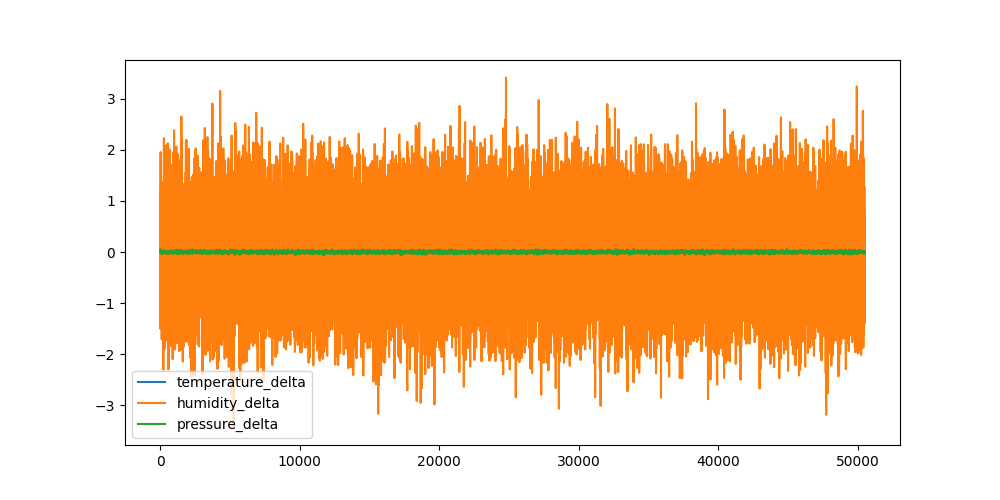

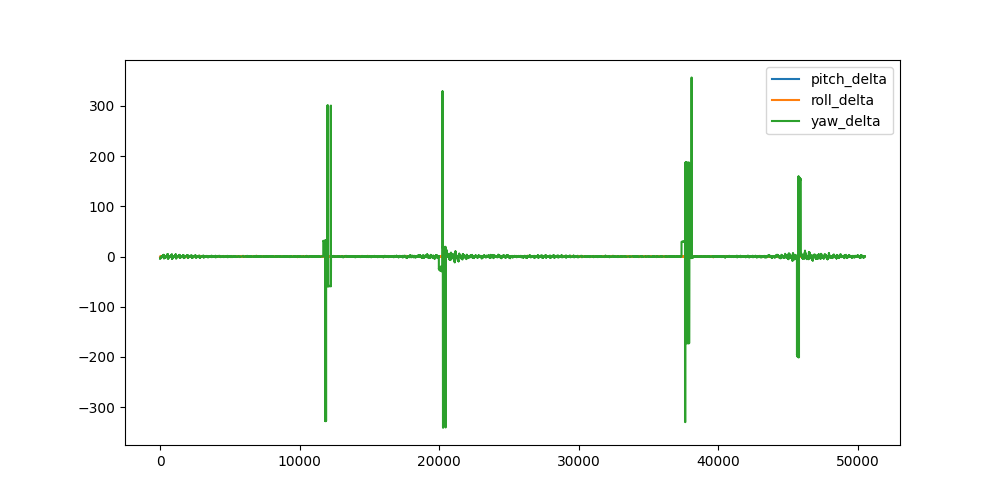

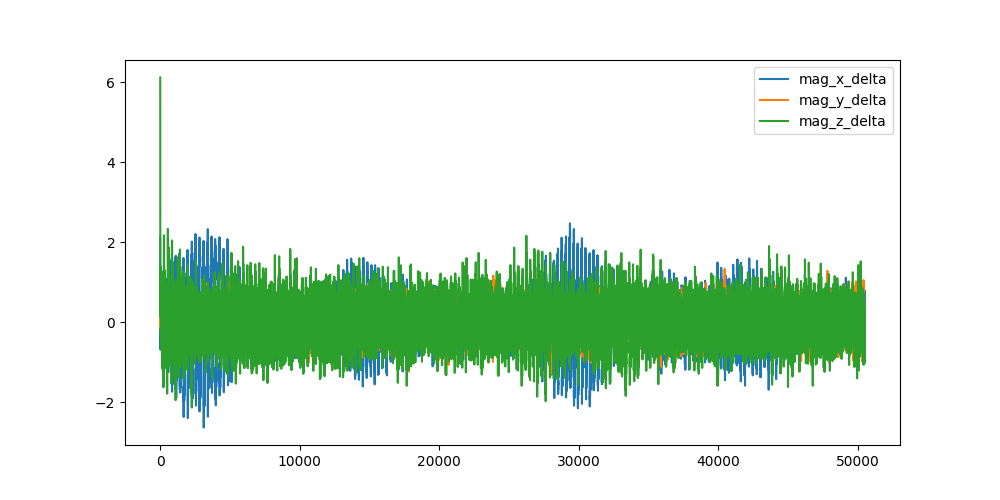

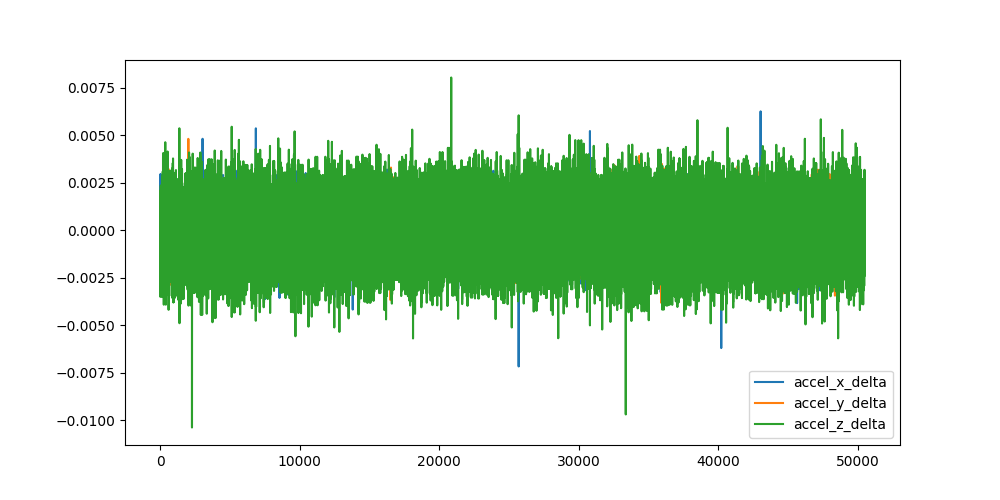

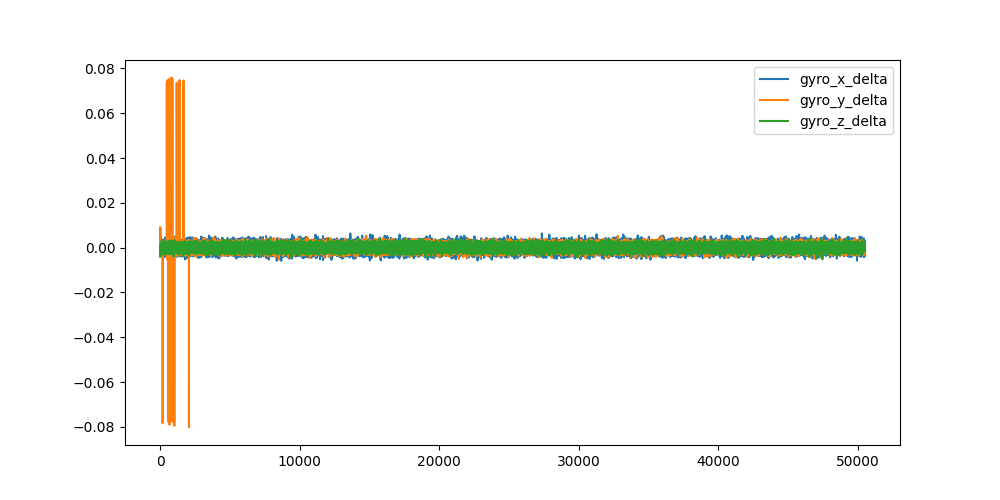

In [33]:
for metrics in [[ele + '_delta' for ele in sub] for sub in metrics_labels]:
    legend = []
    for m in metrics:
        legend.append(m)
    fig, ax = plt.subplots()
    data[metrics].plot(ax=ax, figsize=(10, 5))
    ax.legend(legend)

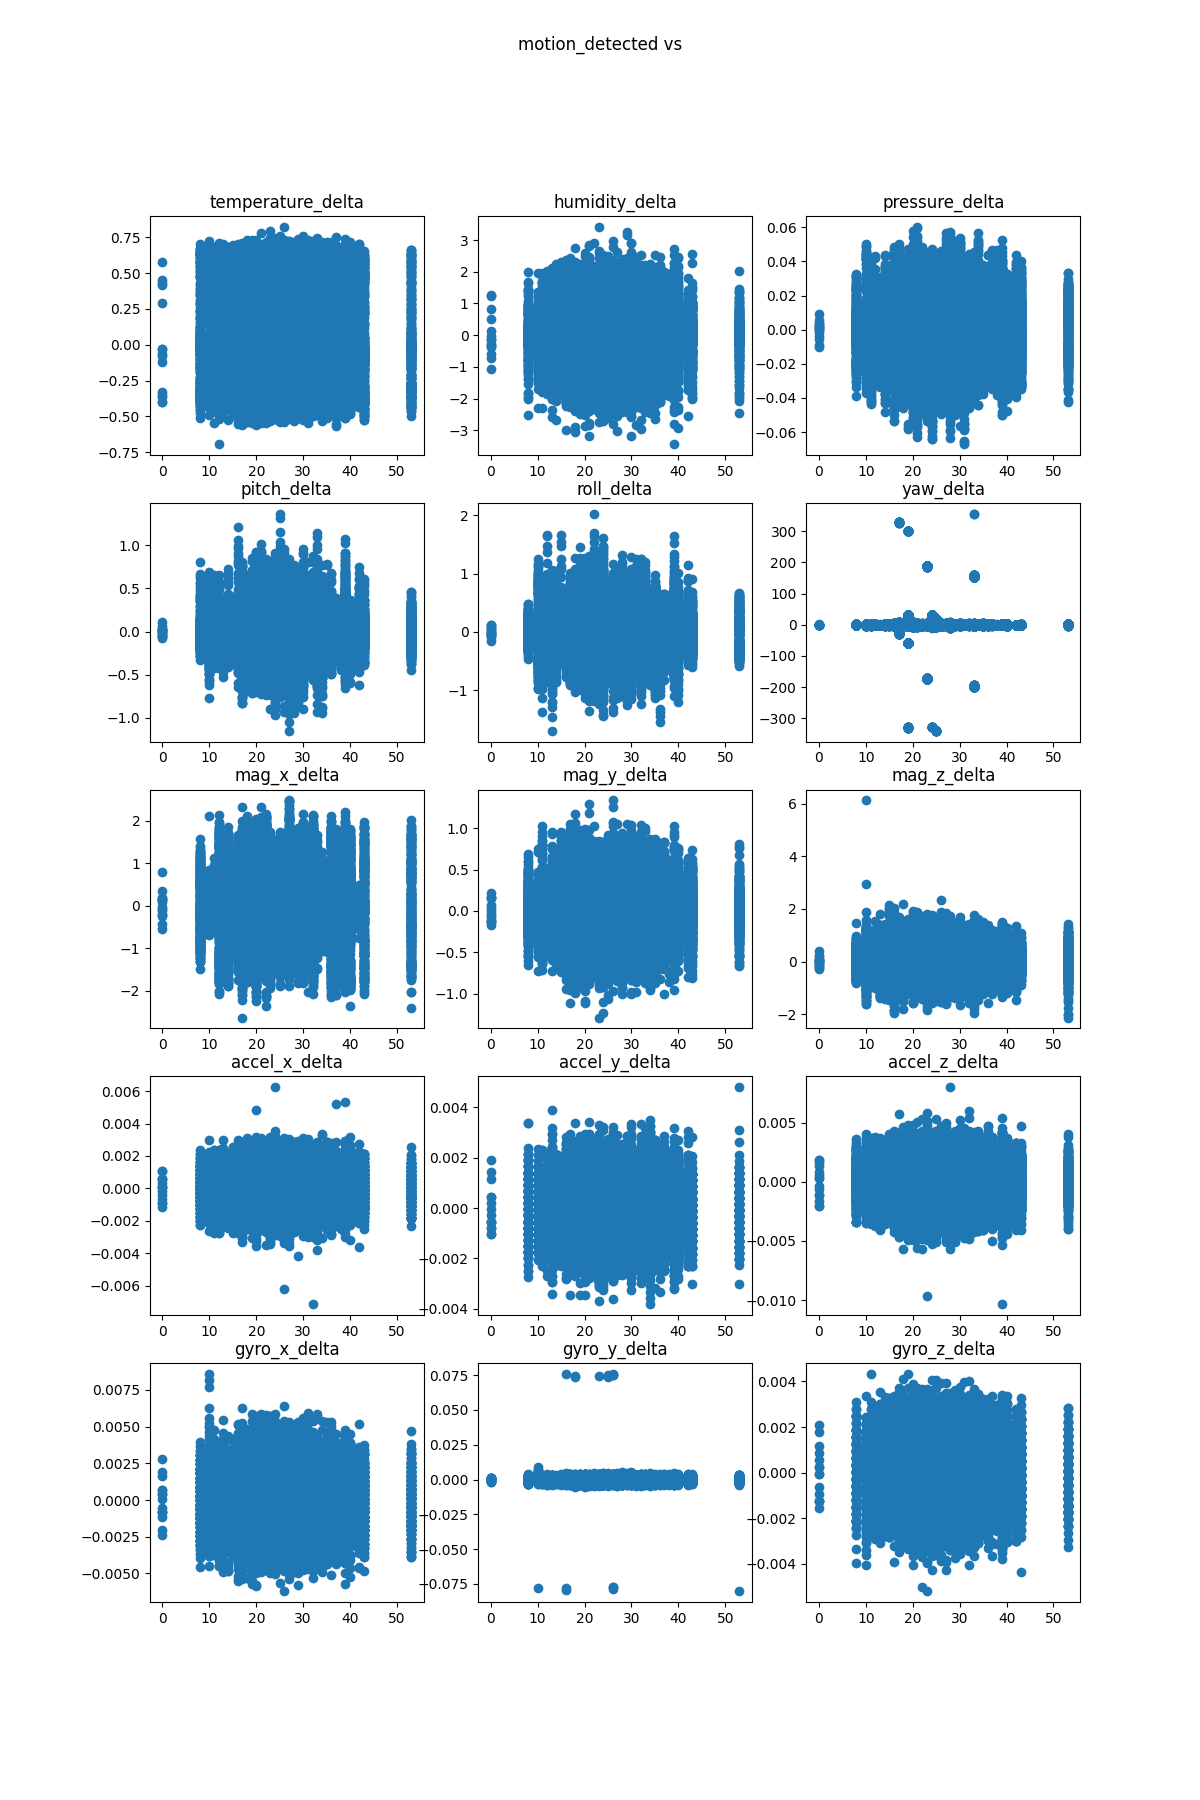

In [34]:
fig, axs = plt.subplots(5,3,figsize=(12,18))
fig.suptitle('motion_detected vs')
i = 0
for metrics in [[ele + '_delta' for ele in sub] for sub in metrics_labels]:
    j = 0
    for m in metrics:
        axs[i, j].scatter(data['motion_detected_sum'], data[m])
        axs[i, j].set_title(m)
        j = j + 1
    i = i + 1
plt.show()

In [35]:
# that means the best Pearson's correlation has value 8.518992e-13: there are no significant correlation 
# https://realpython.com/numpy-scipy-pandas-correlation-python/
df = pd.DataFrame()
for motion in ['motion_detected', 'motion_detected_sum', 'sma10', 'sma20', 'sma30']:
    for metrics in [[ele + '_delta' for ele in sub] for sub in metrics_labels]:
        for m in metrics:
            x = data['motion_detected_sum']
            y = data[m]
            slope, intercept, r, p, stderr = stats.linregress(x, y)
            row = pd.DataFrame({'motion':[motion], 'metrics':[m], 'relation':[r]})
            df = pd.concat([df, row])
df[df['relation'] > 1 / 10**16].sort_values('relation')

motion            metrics      relation
0      motion_detected     humidity_delta  1.181709e-16
0                sma30     humidity_delta  1.181709e-16
0  motion_detected_sum     humidity_delta  1.181709e-16
0                sma20     humidity_delta  1.181709e-16
0                sma10     humidity_delta  1.181709e-16
0                sma30      accel_y_delta  1.844160e-16
0      motion_detected      accel_y_delta  1.844160e-16
0                sma20      accel_y_delta  1.844160e-16
0  motion_detected_sum      accel_y_delta  1.844160e-16
0                sma10      accel_y_delta  1.844160e-16
0                sma30  temperature_delta  3.691758e-16
0                sma20  temperature_delta  3.691758e-16
0      motion_detected  temperature_delta  3.691758e-16
0                sma10  temperature_delta  3.691758e-16
0  motion_detected_sum  temperature_delta  3.691758e-16
0                sma10        pitch_delta  6.125026e-15
0  motion_detected_sum        pitch_delta  6.125026e-15
0                sma20        pitch_delta  6.125026e-15
0      motion_detected        pitch_delta  6.125026e-15
0                sma30        pitch_delta  6.125026e-15
0  motion_detected_sum     pressure_delta  8.518992e-13
0                sma20     pressure_delta  8.518992e-13
0      motion_detected     pressure_delta  8.518992e-13
0                sma30     pressure_delta  8.518992e-13
0                sma10     pressure_delta  8.518992e-13

In [36]:
# that means the best Pearson's correlation has value 0.052060: there are no significant correlation 
# https://realpython.com/numpy-scipy-pandas-correlation-python/
df = pd.DataFrame()
for motion in ['motion_detected', 'motion_detected_sum', 'sma10', 'sma20', 'sma30']:
    for metrics in metrics_labels:
        for m in metrics:
            x = data['motion_detected_sum']
            y = data[m]
            slope, intercept, r, p, stderr = stats.linregress(x, y)
            row = pd.DataFrame({'motion':[motion], 'metrics':[m], 'relation':[r]})
            df = pd.concat([df, row])
df[df['relation'] > 0.01].sort_values('relation')

motion   metrics  relation
0                sma30   accel_z  0.018401
0                sma20   accel_z  0.018401
0      motion_detected   accel_z  0.018401
0                sma10   accel_z  0.018401
0  motion_detected_sum   accel_z  0.018401
0                sma30     pitch  0.022029
0                sma20     pitch  0.022029
0                sma10     pitch  0.022029
0  motion_detected_sum     pitch  0.022029
0      motion_detected     pitch  0.022029
0                sma30     mag_x  0.035376
0                sma10     mag_x  0.035376
0                sma20     mag_x  0.035376
0      motion_detected     mag_x  0.035376
0  motion_detected_sum     mag_x  0.035376
0                sma10  pressure  0.052060
0                sma20  pressure  0.052060
0  motion_detected_sum  pressure  0.052060
0                sma30  pressure  0.052060
0      motion_detected  pressure  0.052060

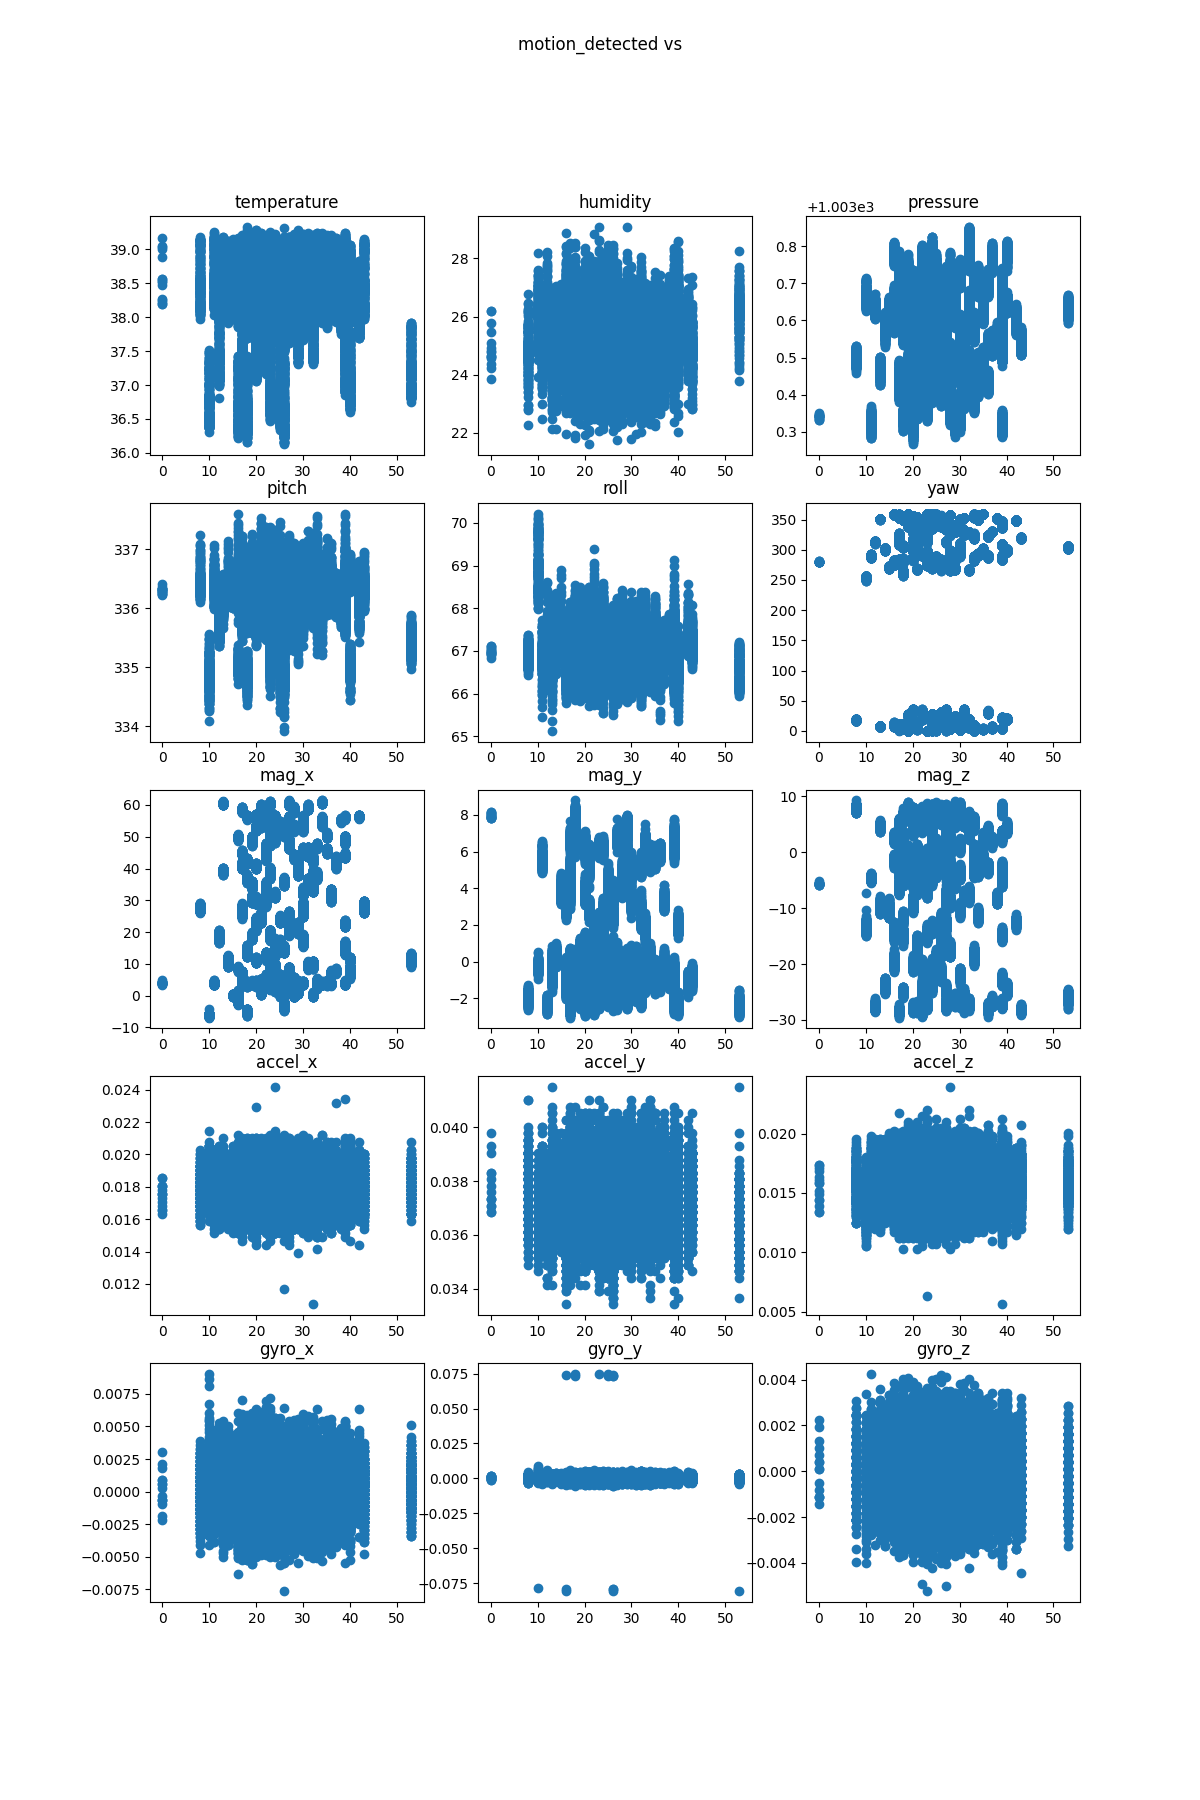

In [37]:
fig, axs = plt.subplots(5,3,figsize=(12,18))
fig.suptitle('motion_detected vs')
i = 0
for metrics in metrics_labels: #[[ele + '_delta' for ele in sub] for sub in metrics_labels]:
    j = 0
    for m in metrics:
        x = data['motion_detected_sum']
        y = data[m]
        axs[i, j].scatter(x, y)
        axs[i, j].set_title(m)
        j = j + 1
    i = i + 1
plt.show()